## Imports

In [10]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import json

## EDA - Basic

In [11]:
df = pd.read_csv('data/train.csv')

In [12]:
df.columns

Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='object')

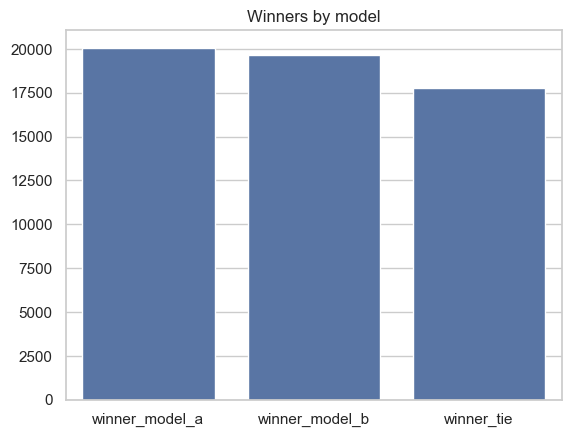

In [13]:
sns.set(style='whitegrid')
sns.barplot(x=['winner_model_a', 'winner_model_b', 'winner_tie'], y=[df['winner_model_a'].sum(), df['winner_model_b'].sum(), df['winner_tie'].sum()])
plt.title('Winners by model')
plt.show()

In [25]:
model_a = df['model_a'].value_counts()
model_b = df['model_b'].value_counts()

model_combined= model_a.add(model_b, fill_value=0).sort_values(ascending=False)

C:\Users\victo\AppData\Local\Temp\ipykernel_9244\121097307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_combined.index, y=model_combined.values, palette=palette, edgecolor=".2", dodge=False, ax=ax)


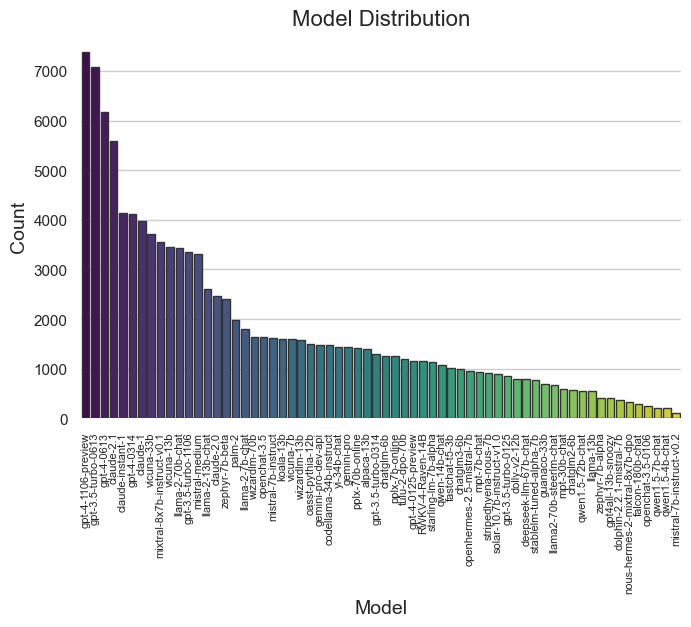

In [58]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("viridis", len(model_combined))

sns.barplot(x=model_combined.index, y=model_combined.values, palette=palette, edgecolor=".2", dodge=False, ax=ax)

ax.set_title('Model Distribution', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Model', fontsize=14)

plt.subplots_adjust(left=0.3)

sns.despine(left=True, bottom=True)

plt.xticks(rotation=90, fontsize=8)

plt.show()

## Possible Models

In this notebook, we are using BERT for the classification task. BERT is a transformer-based model that has been pre-trained on a large corpus of text data. We will use the pre-trained BERT model and fine-tune it on our dataset.

First we need to fix the data and get the tokens for the BERT model =)

### Concat the Question and Answer for each model

Here we supposed to contextualize each question with its corresponding answer. This is done by concatenating the question and the answer. But there's a little problem, each prompt can have multiple answers, so we should concatenate all the answers for each prompt - response in each row.

In [5]:
def concat_qa(row, response_column):
    question = row.get('prompt', '')
    answer = row.get(response_column, '')

    if question is None:
        question = '[]'
    if answer is None:
        answer = '[]'

    try:
        question = json.loads(question)
        answer = json.loads(answer)
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar JSON: {e}")
        return []
    except TypeError as e:
        print(f"Erro ao converter tipos: {e}")
        return []

    qa_list = []

    if not isinstance(question, list) or not isinstance(answer, list):
        print("Erro: question ou answer não são listas.")
        return []

    for item in range(len(question)):
        try:
            if item < len(answer) and isinstance(answer[item], str) and answer[item].strip():
                qa = question[item] + ' ' + answer[item]
            else:
                qa = question[item]
        except (IndexError, TypeError) as e:
            print(f"Erro accessing {item}: {e}")
            qa = question[item] if item < len(question) else ''
        qa_list.append(qa)
    return qa_list

In [6]:
df['qa_model_a'] = df.apply(lambda row: concat_qa(row, 'response_a'), axis=1)
df['qa_model_b'] = df.apply(lambda row: concat_qa(row, 'response_a'), axis=1)

Now we need to EXPLODE the lists inside the Question + Answer columns

In [7]:
df = df[['id','qa_model_a', 'qa_model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']].apply(pd.Series.explode).reset_index(drop=True)

## Tokenization

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_columns(row, tokenizer):

    #LIMIT TOKENIZER LENGTH TO 512!!!!!!!!!!!!!!!!!!!!!!!

    tokens_a= tokenizer.encode_plus(row['qa_model_a'], add_special_tokens=False)
    tokens_b = tokenizer.encode_plus(row['qa_model_b'], add_special_tokens=False)
    
    input_ids = tokenizer.build_inputs_with_special_tokens(tokens_a['input_ids'] + tokens_b['input_ids'])
    
    #Add attention_masks later ?
    return input_ids

In [9]:
df['tokens'] = df.apply(lambda row: tokenize_columns(row, tokenizer), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [ ]:
df.head(10)

,id,qa_model_a,qa_model_b,winner_model_a,winner_model_b,winner_tie,tokens
0,30192,Is it morally right to try to have a certain p...,Is it morally right to try to have a certain p...,1,0,0,"[101, 2003, 2009, 28980, 2157, 2000, 3046, 200..."
1,30192,"OK, does pineapple belong on a pizza? Relax an...","OK, does pineapple belong on a pizza? Relax an...",1,0,0,"[101, 7929, 1010, 2515, 7222, 23804, 7141, 200..."
2,53567,What is the difference between marriage licens...,What is the difference between marriage licens...,0,1,0,"[101, 2054, 2003, 1996, 4489, 2090, 3510, 6105..."
3,53567,How can I get both of them as quick as possibl...,How can I get both of them as quick as possibl...,0,1,0,"[101, 2129, 2064, 1045, 2131, 2119, 1997, 2068..."
4,53567,What is the minimal time to get them? 1 day or...,What is the minimal time to get them? 1 day or...,0,1,0,"[101, 2054, 2003, 1996, 10124, 2051, 2000, 213..."
5,65089,explain function calling. how would you call a...,explain function calling. how would you call a...,0,0,1,"[101, 4863, 3853, 4214, 1012, 2129, 2052, 2017..."
6,96401,How can I create a test set for a very rare ca...,How can I create a test set for a very rare ca...,1,0,0,"[101, 2129, 2064, 1045, 3443, 1037, 3231, 2275..."
7,198779,What is the best way to travel from Tel-Aviv t...,What is the best way to travel from Tel-Aviv t...,0,1,0,"[101, 2054, 2003, 1996, 2190, 2126, 2000, 3604..."
8,292873,"Construct a rap battle, in the style of Epic R...","Construct a rap battle, in the style of Epic R...",0,1,0,"[101, 9570, 1037, 9680, 2645, 1010, 1999, 1996..."
9,313413,Why water is not used in bath tub? Water is ac...,Why water is not used in bath tub? Water is ac...,1,0,0,"[101, 2339, 2300, 2003, 2025, 2109, 1999, 7198..."


## Modelos

In [ ]:
def encoding_labels(row):
    if row['winner_model_a'] == 1:
        return 0
    elif row['winner_model_b'] == 1:
        return 1
    elif row['winner_tie'] == 1:
        return 2

df['label'] = df.apply(lambda row: encoding_labels(row), axis=1)

In [ ]:
#..................... Ainda não implementado =(